# **Penggunaan Pyspark dan Algoritma ALS (*Alternating Least Squares*) Untuk Mesin Rekomendasi Film Berdasarkan Rating dari Movielens**




Dataset: <a href="https://files.grouplens.org/datasets/movielens/ml-25m-README.html">MovieLens dataset</a>

## Import & Install Packages

In [ ]:
!pip install pyspark

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max, avg
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Start a spark session
spark = SparkSession.builder.getOrCreate()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Mengakses & Mengunduh File di Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Data

CSV files are imported and converted to both Pandas and Spark data frames, and are extensively used in this project.

In [ ]:
import gdown
import zipfile
import os

# Fungsi untuk mengunduh file dari Google Drive
def download_file_from_google_drive(id, destination):
    url = 'https://drive.google.com/uc?id=' + id
    gdown.download(url, destination, quiet=False)

# Fungsi untuk mengekstrak file zip
def unzip_file(zip_file, destination):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination)

# ID dari file di Google Drive
file_id = '1iSFV8qdiSdTSSY2EgLm8atDhub2oCbb8'

# Lokasi tempat menyimpan file yang diunduh
downloaded_file = 'file.zip'

# Lokasi tempat ekstraksi file
extracted_folder = 'extracted_folder'

# Unduh file dari Google Drive
download_file_from_google_drive(file_id, downloaded_file)

# Ekstrak file zip
unzip_file(downloaded_file, extracted_folder)

# Hapus file zip jika diperlukan
# os.remove(downloaded_file)

Downloading...
From (original): https://drive.google.com/uc?id=1iSFV8qdiSdTSSY2EgLm8atDhub2oCbb8
From (redirected): https://drive.google.com/uc?id=1iSFV8qdiSdTSSY2EgLm8atDhub2oCbb8&confirm=t&uuid=92ae6c30-92d7-4d16-963f-dac93b78c2de
To: /content/file.zip
100%|██████████| 184M/184M [00:07<00:00, 23.7MB/s]


## Membaca Data dengan Apache Spark

In [ ]:
links = spark.read.csv('/content/extracted_folder/data/links.csv', inferSchema=True, header=True)
movies = spark.read.csv("/content/extracted_folder/data/movies.csv", inferSchema=True, header=True)
ratings = spark.read.csv("/content/extracted_folder/data/ratings.csv", inferSchema=True, header=True)
tags = spark.read.csv("/content/extracted_folder/data/tags.csv", inferSchema=True, header=True)

In [ ]:
links.show(5)
movies.show(5)
ratings.show(5)
tags.show(5)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
+-------+------+------+
only showing top 5 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.

In [ ]:
# Menampilkan jumlah baris dan kolom dari DataFrame links
print("Jumlah baris dan kolom dari DataFrame links:")
print("Jumlah baris:", links.count())
print("Jumlah kolom:", len(links.columns))

# Menampilkan jumlah baris dan kolom dari DataFrame movies
print("\nJumlah baris dan kolom dari DataFrame movies:")
print("Jumlah baris:", movies.count())
print("Jumlah kolom:", len(movies.columns))

# Menampilkan jumlah baris dan kolom dari DataFrame ratings
print("\nJumlah baris dan kolom dari DataFrame ratings:")
print("Jumlah baris:", ratings.count())
print("Jumlah kolom:", len(ratings.columns))

# Menampilkan jumlah baris dan kolom dari DataFrame tags
print("\nJumlah baris dan kolom dari DataFrame tags:")
print("Jumlah baris:", tags.count())
print("Jumlah kolom:", len(tags.columns))

Jumlah baris dan kolom dari DataFrame links:
Jumlah baris: 62423
Jumlah kolom: 3

Jumlah baris dan kolom dari DataFrame movies:
Jumlah baris: 62423
Jumlah kolom: 3

Jumlah baris dan kolom dari DataFrame ratings:
Jumlah baris: 25000095
Jumlah kolom: 4

Jumlah baris dan kolom dari DataFrame tags:
Jumlah baris: 1093360
Jumlah kolom: 4


In [ ]:
# Join tabels
df = ratings.join(movies, ["movieID"], "left")
df = df.join(tags, ["userID", "movieID"], "left")
df = df.drop("tag", "timestamp")

df.show(10)

+------+-------+------+--------------------+--------------------+
|userId|movieId|rating|               title|              genres|
+------+-------+------+--------------------+--------------------+
|     1|    307|   5.0|Three Colors: Blu...|               Drama|
|     1|    899|   3.5|Singin' in the Ra...|Comedy|Musical|Ro...|
|     1|   1088|   4.0|Dirty Dancing (1987)|Drama|Musical|Rom...|
|     1|   1237|   5.0|Seventh Seal, The...|               Drama|
|     1|   1250|   4.0|Bridge on the Riv...| Adventure|Drama|War|
|     1|   1260|   3.5|            M (1931)|Crime|Film-Noir|T...|
| 32906|   1188|   5.0|Strictly Ballroom...|      Comedy|Romance|
| 32906|   1193|   5.0|One Flew Over the...|               Drama|
| 32906|   1198|   5.0|Raiders of the Lo...|    Action|Adventure|
| 32906|   1201|   5.0|Good, the Bad and...|Action|Adventure|...|
+------+-------+------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
# Menampilkan jumlah baris dan kolom dari DataFrame df setelah join tabel
print("Jumlah baris dan kolom dari DataFrame df:")
print("Jumlah baris:", df.count())
print("Jumlah kolom:", len(df.columns))

Jumlah baris dan kolom dari DataFrame df:
Jumlah baris: 25624101
Jumlah kolom: 5


In [ ]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



#### Calculating Sparsity

In [ ]:
# Menghitung jumlah total rating dalam dataset
numerator = df.select("rating").count()

# Menghitung jumlah userId yang unik dan jumlah movieId yang unik
num_users = df.select("userId").distinct().count()
num_movies = df.select("movieId").distinct().count()

# Mengatur penyebut sama dengan jumlah pengguna dikalikan dengan jumlah film
denominator = num_users * num_movies

# Membagi pembilang dengan penyebut
sparsity = (1.0 - (numerator * 1.0) / denominator) * 100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  99.73% empty.


#### Ratings Summary Statistics

In [ ]:
# Menampilkan film dengan jumlah rating terendah
print("Movie with the fewest ratings: ")
df.groupBy("movieID").count().select(min("count")).show()

# Menampilkan rata-rata jumlah rating per film
print("Avg num ratings per movie: ")
df.groupBy("movieID").count().select(avg("count")).show()

# Menampilkan pengguna dengan jumlah rating terendah
print("User with the fewest ratings: ")
df.groupBy("userID").count().select(min("count")).show()

# Menampilkan rata-rata jumlah rating per pengguna
print("Avg num ratings per user: ")
df.groupBy("userID").count().select(avg("count")).show()

Movie with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         1|
+----------+

Avg num ratings per movie: 
+-----------------+
|       avg(count)|
+-----------------+
|433.9610987857131|
+-----------------+

User with the fewest ratings: 
+----------+
|min(count)|
+----------+
|        20|
+----------+

Avg num ratings per user: 
+------------------+
|        avg(count)|
+------------------+
|157.64699983388806|
+------------------+



### Data Visualizations

<ipython-input-13-243b9e93a002>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="rating", data=ratings_pd, alpha=1, palette='Blues')


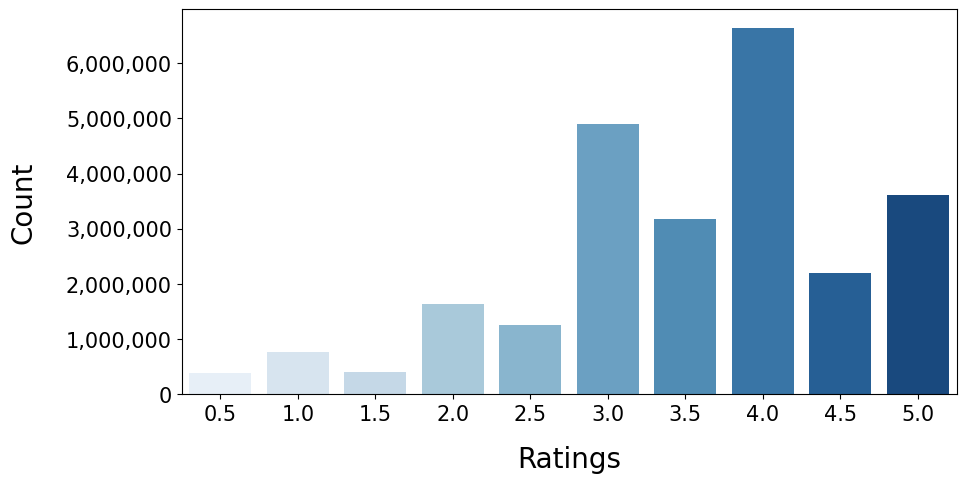

In [ ]:
# Membaca file CSV yang berisi data rating film
ratings_pd = pd.read_csv("/content/extracted_folder/data/ratings.csv")

# Membuat figure dengan ukuran 10x5 inch
plt.figure(figsize=(10, 5))

# Membuat plot count menggunakan seaborn's countplot
# Data yang digunakan adalah kolom 'rating' dari dataframe ratings_pd
# Menggunakan colormap 'coolwarm' untuk warna plot
ax = sns.countplot(x="rating", data=ratings_pd, alpha=1, palette='Blues')

# Mengatur ukuran label pada sumbu x dan y menjadi 15
plt.tick_params(labelsize=15)

# Menambahkan label pada sumbu x dengan teks "Ratings", ukuran font 20, dan jarak antara label dengan sumbu x sebesar 15
plt.xlabel("Ratings", fontsize=20, labelpad=15)

# Menambahkan label pada sumbu y dengan teks "Count", ukuran font 20, dan jarak antara label dengan sumbu y sebesar 20
plt.ylabel("Count", fontsize=20, labelpad=20)

# Mengatur format angka sumbu y agar ditampilkan dalam format tanpa desimal
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

<ipython-input-14-2d32da84dad0>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bow_df['Movie Count'], y=bow_df['Genre'], alpha=1, palette="Blues_d")


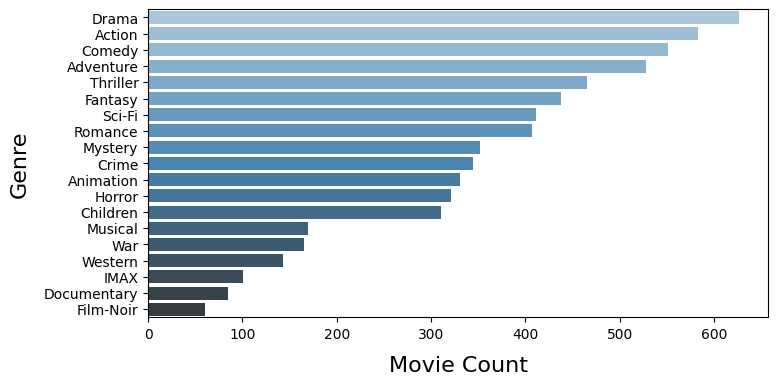

In [ ]:
# Membaca file CSV yang berisi data film
movies_pd = pd.read_csv("/content/extracted_folder/data/movies.csv")

# Menggabungkan genre-genre menjadi satu kolom dan menghapus duplikat
movies_pd['genres'] = movies_pd['genres'].str.replace('|',' ')

# Mengambil unique values dari kolom 'genres' untuk mendapatkan daftar genre unik
movie_genres = movies_pd.genres.unique()

# Menggabungkan semua genre menjadi satu string
movie_genres = " ".join(movie_genres)

# Tokenisasi string genre
word_tokens = word_tokenize(movie_genres)

# Membuat set dari kata-kata yang akan dihapus (stopset)
stopset = ['no', 'genres', 'listed', '(', ')']

# Membersihkan token dari kata-kata dalam stopset
cleanup = [token for token in word_tokens if token not in stopset]

# Menghitung frekuensi kemunculan setiap token
bow = Counter(cleanup)

# Mengonversi dictionary frekuensi menjadi dataframe pandas
bow_dict = dict(bow)
bow_df = pd.DataFrame.from_dict(bow_dict, orient='index', columns=["count"])

# Mengurutkan dataframe berdasarkan count secara menurun
bow_df.sort_values('count', ascending=False, inplace=True)

# Mereset index dataframe
bow_df.reset_index(inplace=True)
bow_df.columns=['Genre', 'Movie Count']

# Membuat subplot dengan ukuran 8x4 inch
fig, ax = plt.subplots(figsize=(8,4))

# Membuat bar plot menggunakan seaborn
sns.barplot(x=bow_df['Movie Count'], y=bow_df['Genre'], alpha=1, palette="Blues_d")

# Menambahkan label pada sumbu x dengan teks "Movie Count", ukuran font 16, dan jarak antara label dengan sumbu x sebesar 10
ax.set_xlabel("Movie Count", fontsize=16, labelpad=10)

# Menambahkan label pada sumbu y dengan teks "Genre", ukuran font 16, dan jarak antara label dengan sumbu y sebesar 10
ax.set_ylabel("Genre", fontsize=16, labelpad=10)

plt.show()

## ALS Base Recommendation Engine

In [ ]:
from pyspark.sql.functions import col, when, explode

## Model ALS dengan parameter default

In [ ]:
# Memisahkan DataFrame df menjadi data pelatihan (training_data) dan data uji (test_data) dengan rasio 80:20
(training_data, test_data) = df.randomSplit([.8, .2])

# Mendefinisikan model ALS (Alternating Least Squares) dengan parameter yang sesuai
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative =True, implicitPrefs = False)

# Melatih model ALS menggunakan data pelatihan (training_data)
model = als.fit(training_data)

# Menghasilkan prediksi pada data uji (test_data) menggunakan model yang telah dilatih
test_predictions = model.transform(test_data)

# Membatasi prediksi agar berada dalam rentang 0-5
test_predictions = test_predictions.withColumn("prediction",
                                               when(col("prediction") < 0, 0).otherwise(col("prediction")))
test_predictions = test_predictions.withColumn("prediction",
                                               when(col("prediction") > 5, 5).otherwise(col("prediction")))

# Menampilkan hasil prediksi yang telah dibatasi
test_predictions.show(5)

+------+-------+------+--------------------+--------------------+----------+
|userId|movieId|rating|               title|              genres|prediction|
+------+-------+------+--------------------+--------------------+----------+
|     1|   4144|   5.0|In the Mood For L...|       Drama|Romance| 3.9978545|
|     1|   8360|   4.0|      Shrek 2 (2004)|Adventure|Animati...|  3.128961|
|     1|   8327|   5.0|        Dolls (2002)|       Drama|Romance| 3.7872388|
|     1|   8973|   4.0|Bad Education (La...|      Drama|Thriller| 3.7395701|
|     1|    899|   3.5|Singin' in the Ra...|Comedy|Musical|Ro...| 3.6803699|
+------+-------+------+--------------------+--------------------+----------+
only showing top 5 rows



#### Membangun evaluator RMSE

RMSE atau *Root Mean Squared Error* digunakan sebagai ukuran akurasi prediksi. Misalnya, diberikan satu set item (film), seberapa baik sistem dapat memprediksi peringkat saya untuk item-item ini, atau seberapa baik sistem dapat memprediksi bahwa saya akan menonton item-item ini.
RMSE biasanya digunakan untuk mengevaluasi masalah regresi di mana output (nilai skalar yang diprediksi) dibandingkan dengan output nilai skalar yang sebenarnya untuk titik data yang diberikan, sehingga cocok untuk evaluasi peringkat bintang lima kami.

In [ ]:
# Mendefinisikan evaluator untuk evaluasi model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [ ]:
# Menggunakan evaluator untuk mengevaluasi DataFrame "test_predictions" dan menghitung RMSE
RMSE = evaluator.evaluate(test_predictions)

# Mencetak nilai RMSE
print (RMSE)

0.8116713249493311


Kode ini mengevaluasi performa model ALS dengan menghitung Root Mean Squared Error (RMSE) antara rating aktual dan prediksi rating pada data uji. Didapatkan RMSE dari model ALS pertama adalah 0,811.


## Model ALS dengan parameter ditentukan

In [ ]:
# Mendefinisikan model ALS dengan parameter yang telah disesuaikan
als2 = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          alpha=0, rank=50, regParam=0.15, maxIter=10,
          coldStartStrategy="drop", nonnegative=True, implicitPrefs=False)

# Melatih model dengan data pelatihan
model = als2.fit(training_data)

# Menggunakan model untuk membuat prediksi pada data uji
test_predictions = model.transform(test_data)
test_predictions.show(5)

+------+-------+------+--------------------+------+----------+
|userId|movieId|rating|               title|genres|prediction|
+------+-------+------+--------------------+------+----------+
|  1260|     31|   3.0|Dangerous Minds (...| Drama|  3.011889|
|  1295|     31|   3.0|Dangerous Minds (...| Drama| 3.1177084|
|  1645|     31|   4.0|Dangerous Minds (...| Drama|  3.406115|
|  2032|     31|   3.0|Dangerous Minds (...| Drama| 3.0787416|
|  2054|     31|   4.0|Dangerous Minds (...| Drama| 2.9145503|
+------+-------+------+--------------------+------+----------+
only showing top 5 rows



In [ ]:
# Menggunakan evaluator untuk mengevaluasi DataFrame "test_predictions" dan menghitung RMSE
RMSE = evaluator.evaluate(test_predictions)

# Mencetak nilai RMSE
print(RMSE)

0.839577231998372


Kode ini mengevaluasi performa model ALS dengan menghitung *Root Mean Squared Error* (RMSE) antara rating aktual dan prediksi rating pada data uji. Didapatkan RMSE dari model ALS pertama adalah 0,839.

## Mesin Rekomendasi Final

In [ ]:
def get_recommendations(user_id):
    recommendations = model.recommendForAllUsers(20)

    recommendations = recommendations.withColumn("recommendations", explode(col("recommendations")))

    recommendations = recommendations.withColumn("recommendations.rating",
                                                 when(col("recommendations.rating") < 0, 0)
                                                 .otherwise(col("recommendations.rating")))
    recommendations = recommendations.withColumn("recommendations.rating",
                                                 when(col("recommendations.rating") > 5, 5)
                                                 .otherwise(col("recommendations.rating")))

    recommendations.createOrReplaceTempView("ALS_recs_temp")
    clean_recs = spark.sql(f"""
        SELECT userId, recommendations.movieId AS movieId, recommendations.rating AS prediction
        FROM ALS_recs_temp
        WHERE userId = {user_id}
    """)

    clean_recs = clean_recs.withColumn("prediction", when(col("prediction") < 0, 0).otherwise(col("prediction")))
    clean_recs = clean_recs.withColumn("prediction", when(col("prediction") > 5, 5).otherwise(col("prediction")))

    # Menggabungkan data rekomendasi dengan data film (movies) berdasarkan movieId
    clean_recs = clean_recs.join(movies, on=['movieId'], how='left').select('title', 'genres', 'prediction')

    # Menambahkan urutan berdasarkan title dan genres setelah prediction
    clean_recs = clean_recs.orderBy(col("prediction").desc(), col("title").asc(), col("genres").asc())

    # Menampilkan hasil rekomendasi
    print(f"Rekomendasi Film Untuk Pengguna Dengan Id {user_id}:")
    clean_recs.show(20, truncate=False)

# Meminta pengguna untuk memasukkan userId
while True:
    user_input = input("Masukkan userId (atau 'k' untuk keluar): ").strip()

    # Keluar dari program jika pengguna memasukkan 'k'
    if user_input.lower() == 'k':
        print("Program Rekomendasi Film Selesai.")
        break

    # Validasi input untuk memastikan itu adalah bilangan bulat
    if not user_input.isdigit():
        print("userId tidak terdaftar, harap masukkan userId yang benar terdaftar.")
        continue

    user_id = int(user_input)

    # Mendapatkan rekomendasi untuk userId yang diberikan
    get_recommendations(user_id)

Masukkan userId (atau 'k' untuk keluar): -1
userId tidak terdaftar, harap masukkan userId yang benar terdaftar.
Masukkan userId (atau 'k' untuk keluar): 1
Rekomendasi Film Untuk Pengguna Dengan Id 1:
+--------------------------------------------------+-----------------------+----------+
|title                                             |genres                 |prediction|
+--------------------------------------------------+-----------------------+----------+
|.hack Liminality In the Case of Kyoko Tohno       |(no genres listed)     |5.0       |
|.hack Liminality In the Case of Yuki Aihara       |(no genres listed)     |5.0       |
|A Dirty Story (1977)                              |(no genres listed)     |5.0       |
|Acı Aşk (2009)                                    |Drama                  |5.0       |
|Adrenaline (1990)                                 |(no genres listed)     |5.0       |
|Familie Brasch (2018)                             |Documentary            |5.0       |
|Head Tr